In [1]:
#to login -- change 'peloton_username' and 'peloton_password' variables in peloton.py
#re-start jupyter kernel and re-run code
from peloton import PelotonWorkout

2021-12-30 16:35:35,204 ERROR: No `username` or `password` found in section `peloton` in ~/.config/peloton
Please ensure you specify one prior to utilizing the API
 [in /Users/spencerkrueger/opt/miniconda3/lib/python3.8/site-packages/peloton/peloton.py:79]


In [180]:
#import all the stuff we need
import pytz
import pandas as pd
import numpy as np

In [267]:
#load all workouts you've done and reverse so oldest are at front of list
workouts = PelotonWorkout.list()
workouts = [ele for ele in reversed(workouts)]

In [275]:
#some functions we'll use to make our dataframe from the api

#takes the start timestamp of a ride and turns it in to yymmdd id (string)
def createStamp(created_at):
    if created_at.day < 10:
        day = "0"+str(created_at.day)
    else:
        day = str(created_at.day)
    if created_at.month < 10:
        month = "0"+str(created_at.month)
    else:
        month = str(created_at.month)
    year = str(created_at.year)
    year = year[2:]

    #stamp = yy/mm/dd
    stamp = year+month+day

    return stamp

def getDayOfWeek(numberDay):
    dayArray = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return dayArray[numberDay]

In [276]:
#create a data frame (table) from api
classDictList = []
counter = 0

for i in workouts:
    print(counter)
    counter += 1
    #some variables aren't in every workout record. so declare those first
    if 'instructor' in dir(i.ride): #scenic rides don't have instructors
        instructor = i. ride.instructor
    else:
        instructor = 'No Instructor'

    if 'calories_summary' in dir(i.metrics): #sometime calories_summary doesn't make it in for floor classes
        calories = i.metrics.calories_summary.value
    else:
        calories = np.nan

    #flag warm up and cool down rides. some are more than 5 minutes so have to search for name in title
    if "Warm Up" in i.ride.title:
        warmUp = True
    else:
        warmUp = False
    if "Cool Down" in i.ride.title:
        coolDown = True
    else:
        coolDown = False

    #convert UTC timestamp to CT
    createdAt = i.created_at.astimezone(pytz.timezone('US/Central'))

    #metrics specific to rides
    if 'output_summary' in dir(i.metrics): #can't just use cycling classes. some dont have output summary
        output = i.metrics.output_summary.value
        distance = i.metrics.distance_summary.value
        outputGraph = i.metrics.output.values
        maxOutput = i.metrics.output.max
        averageOutput = i.metrics.output.average
        cadenceGraph = i.metrics.cadence.values
        maxCadence = i.metrics.cadence.max
        averageCadence = i.metrics.cadence.average
        resistanceGraph = i.metrics.resistance.values
        maxResistance = i.metrics.resistance.max
        averageResistance = i.metrics.resistance.average
        speedGraph = i.metrics.speed.values #speed is supposedly measured in mph
        maxSpeed = i.metrics.speed.max
        averageSpeed = i.metrics.speed.average
        leaderboardRank = i.leaderboard_rank
        leaderboardUsers = i.leaderboard_users
        #achievements seems to not be working. will address later
    else:
        output = np.nan
        distance = np.nan
        outputGraph = np.nan
        maxOutput = np.nan
        averageOutput = np.nan
        cadenceGraph = np.nan
        maxCadence = np.nan
        averageCadence = np.nan
        resistanceGraph = np.nan
        maxResistance = np.nan
        averageResistance = np.nan
        speedGraph = np.nan
        maxSpeed = np.nan
        averageSpeed = np.nan
        leaderboardRank = np.nan
        leaderboardUsers = np.nan

    classDict = {
        'pelotonID':i.ride.id,
        'classPointer':i,
        'title':i.ride.title,
        'subType':i.ride.title[(i.ride.title.find("min")+4):i.ride.title.find(i.ride.title.split()[-1])-1], #im not really sure how to make sense of this yet. could be kind of cool
        'instructor':instructor,
        'dayStamp':createStamp(createdAt),
        'takenAtHour':createdAt.hour,
        'takenAtMinute':createdAt.minute,
        #days of week - monday is 0, sunday is 6
        'takenAtDayOfWeek':getDayOfWeek(createdAt.weekday()),
        'duration':(i.metrics.workout_duration)/60, #duration is in seconds. want minutes
        'fitnessType':i.fitness_discipline,
        'personalRecord':i.personal_record,
        'calories':calories,
        'output':output,
        'distance':distance,
        'outputGraph':outputGraph,
        'maxOutput':maxOutput,
        'averageOutput':averageOutput,
        'cadenceGraph':cadenceGraph,
        'maxCadence':maxCadence,
        'averageCadence':averageCadence,
        'resistanceGraph':resistanceGraph,
        'maxResistance':maxResistance,
        'averageResistance':averageResistance,
        'speedGraph':speedGraph, #speed is supposedly measured in mph
        'maxSpeed':maxSpeed,
        'averageSpeed':averageSpeed,
        'leaderboardRank':leaderboardRank,
        'leaderboardUsers':leaderboardUsers,
        'warmUp':warmUp,
        'coolDown':coolDown,
        'dateTimePointer':i.created_at
        #achievements seems to not be working. will address later
    }
    classDictList.append(classDict)

classDF = pd.DataFrame(classDictList)
classDF.set_index('pelotonID', inplace=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [277]:
classDF

,classPointer,title,subType,instructor,dayStamp,takenAtHour,takenAtMinute,takenAtDayOfWeek,duration,fitnessType,...,maxResistance,averageResistance,speedGraph,maxSpeed,averageSpeed,leaderboardRank,leaderboardUsers,warmUp,coolDown,dateTimePointer
pelotonID,,,,,,,,,,,,,,,,,,,,,
26502eecde964fbd8417018ac6addb70,cycling,30 min New Tracks Ride,New Tracks,Alex Toussaint,201019,17,4,Monday,30.0,cycling,...,56.0,43.0,"[12.4, 12.1, 10.9, 10.0, 10.4, 10.6, 11.5, 11....",26.8,18.1,26139.0,72742.0,False,False,2020-10-19 22:04:39+00:00
1533f607c4c24c378d27a679eefdda78,cycling,30 min 2010s Ride,2010s,Sam Yo,201020,11,26,Tuesday,30.0,cycling,...,71.0,48.0,"[10.5, 10.4, 10.7, 10.7, 10.5, 10.4, 10.5, 10....",27.0,19.1,2169.0,12402.0,False,False,2020-10-20 16:26:32+00:00
6c4e672478f84c999795bc5f9d145b74,cycling,20 min Pop Ride,Pop,Cody Rigsby,201021,11,49,Wednesday,20.0,cycling,...,74.0,45.0,"[13.1, 13.6, 13.3, 13.2, 12.9, 13.0, 13.7, 13....",26.3,18.5,10727.0,118745.0,False,False,2020-10-21 16:49:17+00:00
c008239fd8ad4bf5bc82b6bfbc5a9304,cycling,30 min Lizzo Ride,Lizzo,Robin Arzón,201023,15,2,Friday,30.0,cycling,...,69.0,47.0,"[7.7, 7.9, 7.9, 8.7, 10.6, 11.1, 11.1, 13.4, 1...",28.0,19.6,33006.0,472519.0,False,False,2020-10-23 20:02:50+00:00
f55c8dd2aa6b4fc49e0ea30aa9fb7fa8,cycling,30 min HIIT Ride,HIIT,Hannah Frankson,201025,14,29,Sunday,30.0,cycling,...,64.0,46.0,"[1.6, 2.4, 6.3, 6.6, 9.6, 8.5, 13.8, 15.2, 15....",27.9,19.8,1826.0,13309.0,False,False,2020-10-25 19:29:59+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7ea1e44eeaf74011ac785fd98b15b634,stretching,5 min Lower Body Stretch,Lower Body,Ben Alldis,211222,17,55,Wednesday,5.0,stretching,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,2021-12-22 23:55:02+00:00
53e953529589410bb555097e9dae2a05,cycling,45 min Heat It Up Ride: Boxing Day,Heat It Up Ride: Boxing,Ben Alldis,211227,10,25,Monday,45.0,cycling,...,66.0,47.0,"[15.7, 15.7, 15.6, 15.5, 15.5, 15.6, 15.6, 15....",27.1,20.3,3283.0,17074.0,False,False,2021-12-27 16:25:16+00:00
fce0b6965a8c4795a22bdc0e741fef68,stretching,5 min Post-Ride Stretch,Post-Ride,Leanne Hainsby,211227,11,17,Monday,5.0,stretching,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,2021-12-27 17:17:08+00:00


Plots

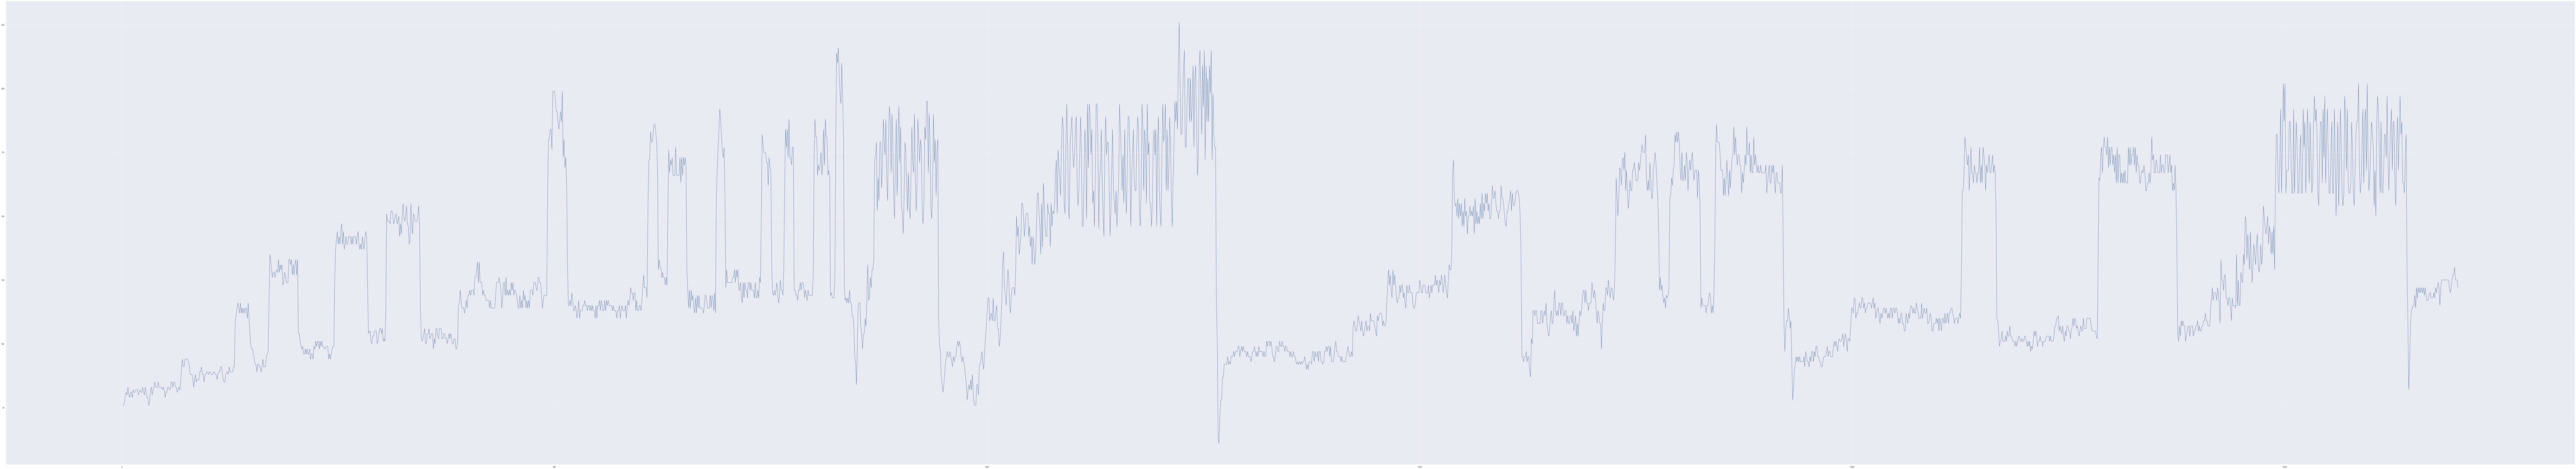

In [94]:
import matplotlib.pyplot as plt

xVals = []
yVals = test
for i in range(1, len(test)+1):
    xVals.append(i)

fig = plt.figure(figsize = ((45*60)/10,500/10))
plt.plot(xVals, yVals)

In [79]:
for i in (rideDF.instructor).unique():
    rideDF[str(i) + "Count"] = (rideDF["instructor"] == i).cumsum()
rideDF

,date,instructor,Alex ToussaintCount,Sam YoCount,Cody RigsbyCount,Robin ArzónCount,Hannah FranksonCount,Multiple InstructorsCount,Leanne HainsbyCount,Kendall TooleCount,...,Denis MortonCount,Ben AlldisCount,Hannah CorbinCount,Ally LoveCount,Denis & MattCount,Bradley RoseCount,Cody & EmmaCount,Cliff DwengerCount,Cliff & HannahCount,Jess KingCount
0,2020-10-19 17:04:39-05:00,Alex Toussaint,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-10-20 11:26:32-05:00,Sam Yo,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-10-21 11:49:17-05:00,Cody Rigsby,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-10-23 15:02:50-05:00,Robin Arzón,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-10-25 14:29:59-05:00,Hannah Frankson,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,2021-12-08 16:21:21-06:00,Leanne Hainsby,45,1,30,1,7,1,32,4,...,16,18,5,1,1,2,1,3,1,0
220,2021-12-08 16:54:13-06:00,Olivia Amato,45,1,30,1,7,1,32,4,...,16,18,5,1,1,2,1,3,1,0
221,2021-12-08 17:10:51-06:00,Jess King,45,1,30,1,7,1,32,4,...,16,18,5,1,1,2,1,3,1,1
222,2021-12-13 17:17:16-06:00,Olivia Amato,45,1,30,1,7,1,32,4,...,16,18,5,1,1,2,1,3,1,1


In [96]:
rideDF['count'] = ""
for i in rideDF.index:
    column = str(rideDF.iloc[i].instructor) + "Count"
    rideDF.at[i,'count'] = rideDF.iloc[i][column]

rideDF = rideDF[['date','instructor','count']]

In [99]:
#visualize the instructors over time
import plotly.express as px

fig = px.line(rideDF, x="date", y="count", color='instructor')
fig.show()

In [313]:
#import plotly.express as px

#fig = px.line(rideDF, x="date", y="count", color='instructor')
#fig.show()

sampleClassDF = classDF.loc[(classDF.fitnessType == "cycling") & (classDF.warmUp == False) & (classDF.coolDown == False),['classPointer','title','output','averageOutput','dateTimePointer','duration','dayStamp']]
sampleClassDF = sampleClassDF.astype({'duration':str})
sampleClassDF = sampleClassDF.drop(sampleClassDF.index[[99]])
sampleClassDF

,classPointer,title,output,averageOutput,dateTimePointer,duration,dayStamp
pelotonID,,,,,,,
26502eecde964fbd8417018ac6addb70,cycling,30 min New Tracks Ride,246.0,137.0,2020-10-19 22:04:39+00:00,30.0,201019
1533f607c4c24c378d27a679eefdda78,cycling,30 min 2010s Ride,289.0,161.0,2020-10-20 16:26:32+00:00,30.0,201020
6c4e672478f84c999795bc5f9d145b74,cycling,20 min Pop Ride,174.0,145.0,2020-10-21 16:49:17+00:00,20.0,201021
c008239fd8ad4bf5bc82b6bfbc5a9304,cycling,30 min Lizzo Ride,303.0,170.0,2020-10-23 20:02:50+00:00,30.0,201023
f55c8dd2aa6b4fc49e0ea30aa9fb7fa8,cycling,30 min HIIT Ride,321.0,178.0,2020-10-25 19:29:59+00:00,30.0,201025
...,...,...,...,...,...,...,...
e9c5f89488f34110a92d537d30f7e3bc,cycling,"30 min XOXO, Cody: Slay Ride",354.0,196.0,2021-12-21 22:56:45+00:00,30.0,211221
494bbbe3b262476b9452ca0fc5360f29,cycling,30 min Tabata Ride,368.0,204.0,2021-12-21 23:27:58+00:00,30.0,211221
5dd70d1227dd4b819937d562694a9108,cycling,20 min House Ride,259.0,216.0,2021-12-22 23:30:49+00:00,20.0,211222


In [315]:
import plotly.express as px
import plotly.graph_objects as go
fig1 = px.scatter(sampleClassDF, x="dateTimePointer", y='output',
                 trendline="lowess",color="duration")
fig1.show()

In [316]:
fig2 = px.scatter(sampleClassDF, x="dateTimePointer", y='averageOutput',
                  trendline="lowess",color="duration")
fig2.show()

The graph above kind of works. But I see two problems:
1. sometimes there are outliers - the 30 min class these shouldn't be graphed because clearly they are classes that I didn't really do. but I don't want to remove them without manually looking at them because there aren't that many instances. the best thing is just to manually delete the class on peloton account
2. average output might not be that helpful. will probably want to look at total output or group all classes from a day together

In [317]:
#visualize average output per instructor over time
groupWorkouts = sampleClassDF[['dayStamp','output','duration']].groupby('dayStamp').sum()
groupWorkouts

,output
dayStamp,
201019,246.0
201020,289.0
201021,174.0
201023,303.0
201025,321.0
...,...
211219,3.0
211221,722.0
211222,259.0
